<a href="https://colab.research.google.com/github/gimhaninavodya/SE4050-Lab-8-DeepLearning/blob/main/Reinforcement_Learning_Lab_2_Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and setup

In [8]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Q-Network

In [9]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer

In [10]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states, dtype=np.float32), actions, rewards, np.array(next_states, dtype=np.float32), dones

    def __len__(self):
        return len(self.buffer)

# DQN Agent

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size=64, lr=1e-3,
                 gamma=0.99, buffer_size=100000, batch_size=64,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 target_update_freq=1000):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.step_count = 0

        # Online & target networks
        self.q_network = QNetwork(state_size, action_size, hidden_size).to(device)
        self.target_network = QNetwork(state_size, action_size, hidden_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state)
            return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # Compute current Q values
        q_values = self.q_network(states).gather(1, actions)

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss
        loss = self.loss_fn(q_values, target_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.step_count += 1
        if self.step_count % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.item()

# Training Loop

In [12]:
# I could not use LunarLander-v2 in Colab because it needs the Box2D physics engine, which requires the Python package box2d-py.
# It cannot compile properly on Colab’s environment.
# So, chose the CartPole-v1 instead.


def train_dqn(env_name="CartPole-v1", episodes=500):
    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    episode_rewards = []
    epsilons = []
    losses = []

    for episode in range(episodes):
        state = env.reset()[0]
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.store_transition(state, action, reward, next_state, done)
            loss = agent.update()
            if loss is not None:
                losses.append(loss)

            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)
        epsilons.append(agent.epsilon)

        print(f"Episode {episode+1}/{episodes}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    env.close()
    return episode_rewards, epsilons, losses

# Run Training

In [13]:
episode_rewards, epsilons, losses = train_dqn(episodes=300)

Episode 1/300, Reward: 18.00, Epsilon: 1.000
Episode 2/300, Reward: 29.00, Epsilon: 1.000
Episode 3/300, Reward: 10.00, Epsilon: 1.000
Episode 4/300, Reward: 16.00, Epsilon: 0.951
Episode 5/300, Reward: 19.00, Epsilon: 0.865
Episode 6/300, Reward: 68.00, Epsilon: 0.615
Episode 7/300, Reward: 22.00, Epsilon: 0.551
Episode 8/300, Reward: 10.00, Epsilon: 0.524
Episode 9/300, Reward: 22.00, Epsilon: 0.469
Episode 10/300, Reward: 24.00, Epsilon: 0.416
Episode 11/300, Reward: 56.00, Epsilon: 0.314
Episode 12/300, Reward: 16.00, Epsilon: 0.290
Episode 13/300, Reward: 12.00, Epsilon: 0.273
Episode 14/300, Reward: 16.00, Epsilon: 0.252
Episode 15/300, Reward: 10.00, Epsilon: 0.240
Episode 16/300, Reward: 11.00, Epsilon: 0.227
Episode 17/300, Reward: 11.00, Epsilon: 0.215
Episode 18/300, Reward: 9.00, Epsilon: 0.205
Episode 19/300, Reward: 11.00, Epsilon: 0.194
Episode 20/300, Reward: 10.00, Epsilon: 0.185
Episode 21/300, Reward: 10.00, Epsilon: 0.176
Episode 22/300, Reward: 11.00, Epsilon: 0.16

# Plot Results

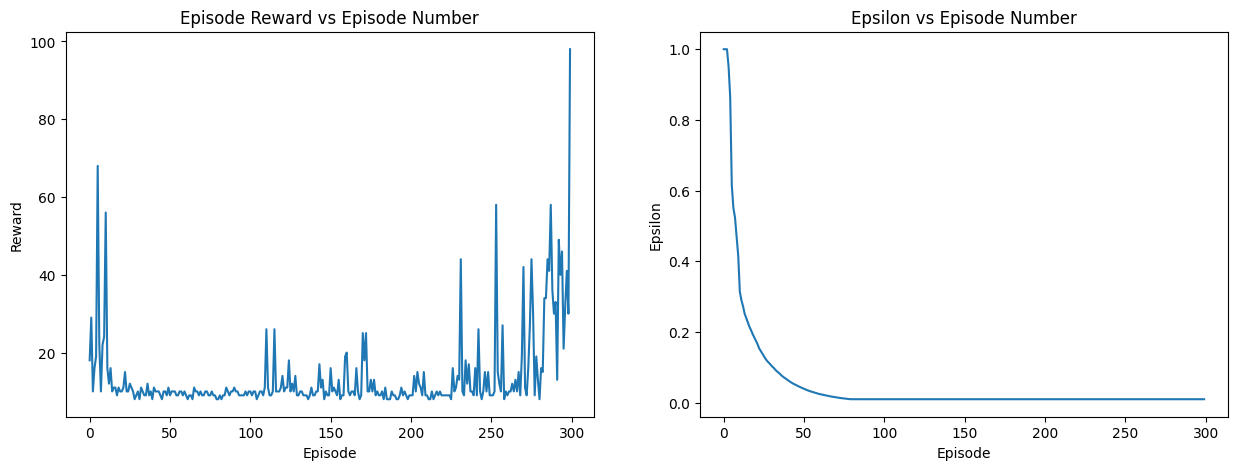

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Reward vs Episode Number")

plt.subplot(1,2,2)
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon vs Episode Number")
plt.show()

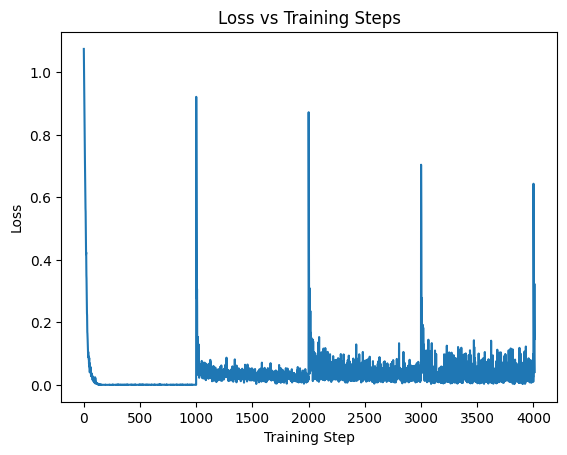

In [17]:
# plot loss
plt.figure()
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss vs Training Steps")
plt.show()